In [2]:
%%html
<style>
table {align:left;display:block}
</style>

In [3]:
import pandas as pd
import matplotlib.pyplot as pp
import numpy as np

In [6]:
demo = pd.read_sas('DEMO_J.xpt', format='xport')

The `DEMO_J.xpt` demographics file provides individual, family, and household-level information
* SEQN - Respondent sequence number
* RIAGENDR - Gender
| Code or Value | Value Description | Count | Cumulative |
|:-------------:|:-----------------:|:-----:|:----------:|
|       1       |        Male       |  4557 |    4557    |
|       2       |       Female      |  4697 |    9254    |
|       .       |      Missing      |   0   |    9254    |
* RIDAGEYR - Age in years at screening
| Code or Value |     Value Description    | Count | Cumulative |
|:-------------:|:------------------------:|:-----:|:----------:|
|    0 to 79    |      Range of Values     |  8827 |    8827    |
|       80      | 80 years of age and over |  427  |    9254    |
|       .       |          Missing         |   0   |    9254    |
* RIDRETH3 - Race/Hispanic origin w/ NH Asian
| Code or Value |          Value Description          | Count | Cumulative |
|:-------------:|:-----------------------------------:|:-----:|:----------:|
|       1       |           Mexican American          |  1367 |    1367    |
|       2       |            Other Hispanic           |  820  |    2187    |
|       3       |          Non-Hispanic White         |  3150 |    5337    |
|       4       |          Non-Hispanic Black         |  2115 |    7452    |
|       6       |          Non-Hispanic Asian         |  1168 |    8620    |
|       7       | Other Race - Including Multi-Racial |  634  |    9254    |
|       .       |               Missing               |   0   |    9254    |


In [7]:
body = pd.read_sas('BMX_J.xpt', format='xport')

`BMX_J.xpt` file keeps the body measures of the survey participants

* SEQN - Respondent sequence number
* BMXBMI - Body Mass Index (kg/m^2). *Target:Both males and females 2 YEARS - 150 YEARS*
| Code or Value | Value Description | Count | Cumulative |
|:-------------:|:-----------------:|:-----:|:----------:|
|  12.3 to 86.2 |  Range of Values  |  8005 |    8005    |
|       .       |      Missing      |  699  |    8704    |

In [8]:
# inner joing 2 tables by respondent id
df = (pd.merge(demo[['SEQN','RIAGENDR','RIDAGEYR','RIDRETH3']], #keeping only id, gender, age, race
               body[['SEQN','BMXBMI']].dropna(), #keeping only id and non-null BMI
               on='SEQN'))

In [9]:
# race dataset - code / value
races = ['Mexican American',
         'Other Hispanic',
         'Non-Hispanic White',
         'Non-Hispanic Black',
         'Non-Hispanic Asian',
         'Other Race - Including Multi-Racial']
race = (pd.DataFrame({'RIDRETH3':[1,2,3,4,6,7],
               'RACE':races}))

In [10]:
# gender dataset - code / value
gender = (pd.DataFrame({'RIAGENDR':[1,2],
                        'GENDER':['Male','Female']}))

In [11]:
df = (df.merge(race, # inner joining race
          on='RIDRETH3').merge(gender, # inner joining gender
                               on='RIAGENDR'))

In [12]:
# group by the race and calculate the average body mass index (BMI) for each race
groupbyrace = (df.groupby(['RACE','GENDER'])
               .BMXBMI.mean() # average
               .unstack(level=1) # pivot second index GENDER
               .reindex(races[::-1])) # sorting by the original list in reserse order

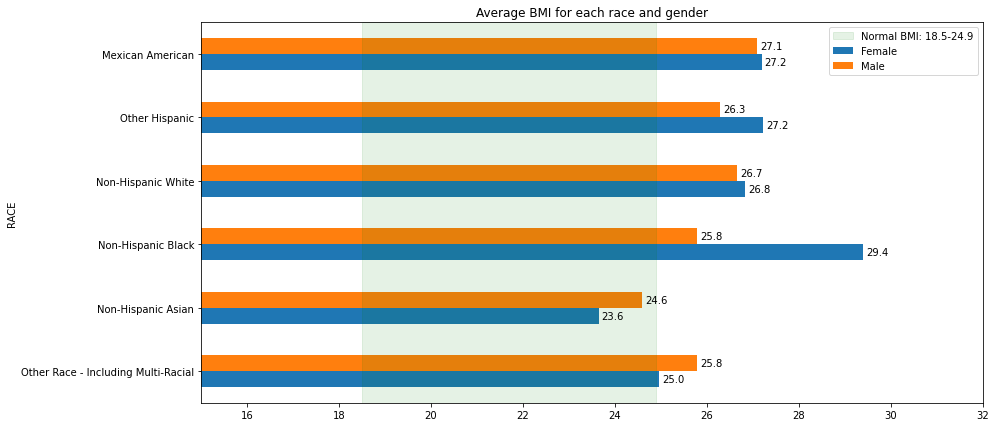

In [37]:
# plotting avg BMI by race and gender
ax = groupbyrace.plot.barh(figsize=(14,7), # (width, height) in inches
                           title='Average BMI for each race and gender') 

# annotating with data labels
for bars in ax.containers:
    ax.bar_label(bars, 
                 fmt='%.1f',
                 padding=3)

# plotting normal BMI
pp.axvspan(18.5, 24.9,
          alpha=0.1,
          color='g',
          label='Normal BMI: 18.5-24.9')

pp.axis(xmin=15, xmax=32)
pp.legend()

In [15]:
# adding new column for age groups
df['GROUP'] = np.where(df['RIDAGEYR'].between(2,14), 'Children', # 2-14 years
                      np.where(df['RIDAGEYR'].between(15,24), 'Youth', # 15-24 years
                              np.where(df['RIDAGEYR'].between(25,64), 'Adults', 'Seniors'))) # 25-64 and 65+ years

In [31]:
# group by the race and age group. Calculate the average body mass index (BMI) for each race and age group
groupbyage = (df.groupby(['RACE','GROUP'])
              .BMXBMI.mean() # average
              .unstack(level=1) # pivot second index GROUP
              .reindex(columns=['Children','Youth','Adults','Seniors']) # sorting columns by the list
              .reindex(races) # sorting rows by the list
             )

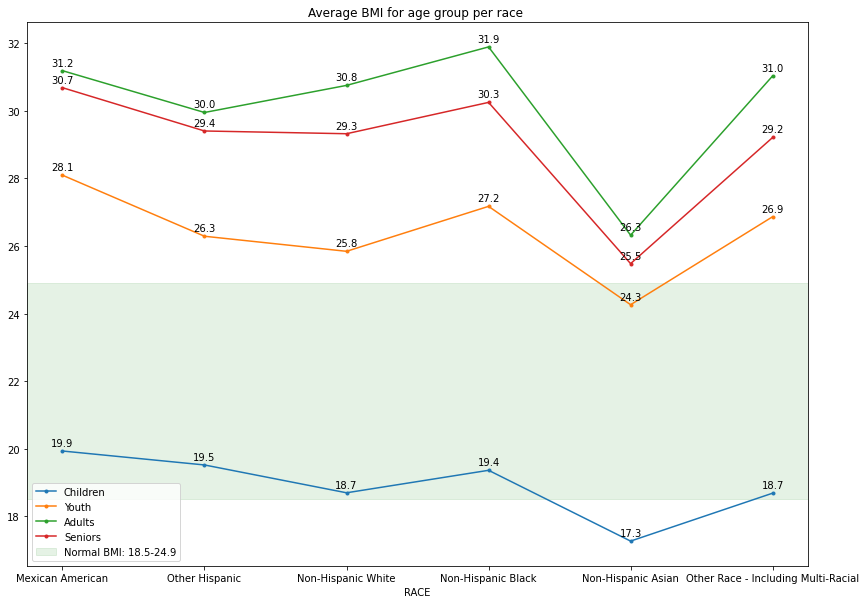

In [34]:
# plotting avg BMI by race and group
ax = groupbyage.plot(figsize=(14,10), # (width, height) in inches
                     marker = ".", 
                     title='Average BMI for age group per race ')

# annotating with data labels
for line in ax.lines:
    for xval, yval in zip(line.get_xdata(), line.get_ydata()):
        ax.annotate(f'{yval:.1f}', 
                    xy=(xval,yval), 
                    xytext=(0, 5), 
                    textcoords="offset points", 
                    ha='center')

# plotting normal BMI
pp.axhspan(18.5, 24.9,
          alpha=0.1,
          color='g',
          label='Normal BMI: 18.5-24.9')

pp.legend()